In [134]:
# import libraries
import re    #for regex
from tqdm import tqdm
from collections import Counter
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.feature_selection import SelectKBest
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
eng_stopwords = set(stopwords.words("english"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [135]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


In [136]:
train = pd.read_csv("datasets/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3,encoding='utf-8') 
test = pd.read_csv("datasets/testData.tsv", header=0, \
                    delimiter="\t", quoting=3,encoding='utf-8')

In [137]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [138]:
#concat both train and test
merged=pd.concat([train[['id','review']],test[['id','review']]])
merged=merged.reset_index(drop=True)
# restrain dimensions to first 5000
merged=merged[:5000]
train=train[:5000]
test=test[:5000]
print merged.head()
#df.iloc[25000:] is test set
#df.iloc[:25000] is train set

         id                                             review
0  "5814_8"  "With all this stuff going down at the moment ...
1  "2381_9"  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"  "The film starts with a manager (Nicholas Bell...
3  "3630_4"  "It must be assumed that those who praised thi...
4  "9495_8"  "Superbly trashy and wondrously unpretentious ...


In [139]:
# Import BeautifulSoup into your workspace
# use beautiful soup to remove html tags
from bs4 import BeautifulSoup             

# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(train["review"][0], 'lxml')  

# Print the raw review and then the output of get_text(), for 
# comparison
print example1.get_text()

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 20 mi

In [140]:
#dictionary of apostrophe words
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

In [141]:
def initial_clean(raw_text):
    # split words and lowercase
    # 1. Remove HTML
    raw_text = BeautifulSoup(raw_text, 'lxml').get_text() 
    
    words = raw_text.lower().split() 
    # convert contractions into individual words
    words=[APPO[word] if word in APPO else word for word in words]
    # join words
    words=" ".join(words)
    # return only words
    letters_only = re.sub("[^a-zA-Z]", " ", words)
    words=tokenizer.tokenize(letters_only)
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    clean_sent=" ".join(words)

    
    return clean_sent

In [142]:
merged['cleaned_review']=merged['review'].apply(initial_clean)
merged['cleaned_review'].head(5)[0]

u'stuff go moment mj I start listen music watch odd documentary watch wiz watch moonwalker maybe want get certain insight guy think really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember go see cinema originally release subtle message mj feel towards press also obvious message drug bad kay visually impressive course michael jackson unless remotely like mj anyway go hate find bore may call mj egotist consent make movie mj fan would say make fan true really nice actual feature film bite finally start minutes exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad beyond mj overhear plan nah joe pesci character rant want people know supply drug etc dunno maybe hat mj music lot cool things like mj turn car robot whole speed demon sequence also director must patience saint come film kiddy bad sequence usually directors hate work one kid let alone whole bunch perform complex dance scene bo

In [143]:
merged['review_count_word']=merged["cleaned_review"].apply(lambda x: len(str(x).split()))
merged['review_count_unique_word']=merged["cleaned_review"].apply(lambda x: len(set(str(x).split())))#split creates groups
merged['review_count_letters']=merged["cleaned_review"].apply(lambda x: len(str(x)))
merged["review_mean_word_len"] = merged["cleaned_review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
merged['review_word_unique_percent']=merged['review_count_unique_word']*100.0/merged['review_count_word']
merged.head()

,id,review,cleaned_review,review_count_word,review_count_unique_word,review_count_letters,review_mean_word_len,review_word_unique_percent
0,"""5814_8""","""With all this stuff going down at the moment ...",stuff go moment mj I start listen music watch ...,221,156,1356,5.140271,70.588235
1,"""2381_9""","""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertain fil...,84,65,574,5.845238,77.380952
2,"""7759_3""","""The film starts with a manager (Nicholas Bell...",film start manager nicholas bell give welcome ...,240,206,1728,6.204167,85.833333
3,"""3630_4""","""It must be assumed that those who praised thi...",must assume praise film greatest film opera ev...,191,160,1393,6.298429,83.769634
4,"""9495_8""","""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...,210,189,1465,5.980952,90.000000


In [144]:
merged=merged.drop(columns=['id'])

In [145]:
# request
tfv = TfidfVectorizer(min_df=3,  max_features=30000, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
merged_tfv=tfv.fit_transform(merged['cleaned_review']) 
features=[x for x in np.array(tfv.get_feature_names())]

print len(features)
merged_tvec = pd.DataFrame(merged_tfv.toarray(),columns=features)
merged_tvec.head()

30000


,aag,aamir,aaron,abandon,abandon baby,abandon build,abandonment,abbot,abbot costello,abbott,...,zombie movies,zombie relate,zombie remake,zombies,zombies come,zone,zoo,zoom,zorro,zuniga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#train_target.select_dtypes(include=numerics).to_csv('train_target.csv',index=False,encoding='utf-8')
numeric_merged=merged.select_dtypes(include=numerics)
numeric_merged.head()

,review_count_word,review_count_unique_word,review_count_letters,review_mean_word_len,review_word_unique_percent
0,221,156,1356,5.140271,70.588235
1,84,65,574,5.845238,77.380952
2,240,206,1728,6.204167,85.833333
3,191,160,1393,6.298429,83.769634
4,210,189,1465,5.980952,90.000000


In [147]:
target=train['sentiment']
tvec_corr=pd.concat([target,numeric_merged[:len(train)],merged_tvec[:len(train)]],axis=1)

tvec_corr = tvec_corr.iloc[:,1:].corrwith(target)
tvec_corr.sort_values(ascending=False).head(20)

great                   0.217520
love                    0.166498
excellent               0.163653
wonderful               0.149636
best                    0.145705
perfect                 0.135946
highly recommend        0.130902
beautiful               0.129260
highly                  0.121366
favorite                0.112016
recommend               0.109405
fantastic               0.103890
heart                   0.102347
young                   0.100190
family                  0.099205
review_mean_word_len    0.098304
enjoy                   0.097759
amaze                   0.093588
live                    0.092864
superb                  0.092694
dtype: float64

In [148]:
tvec_corr.sort_values(ascending=True).head(20)

bad          -0.293225
worst        -0.250341
waste        -0.224521
awful        -0.197366
poor         -0.174312
stupid       -0.163775
worse        -0.154876
waste time   -0.150978
terrible     -0.146238
bore         -0.141412
plot         -0.131199
horrible     -0.129565
look like    -0.128825
minutes      -0.127098
crap         -0.126503
act          -0.122382
script       -0.122252
dull         -0.121555
suppose      -0.118878
poorly       -0.117506
dtype: float64

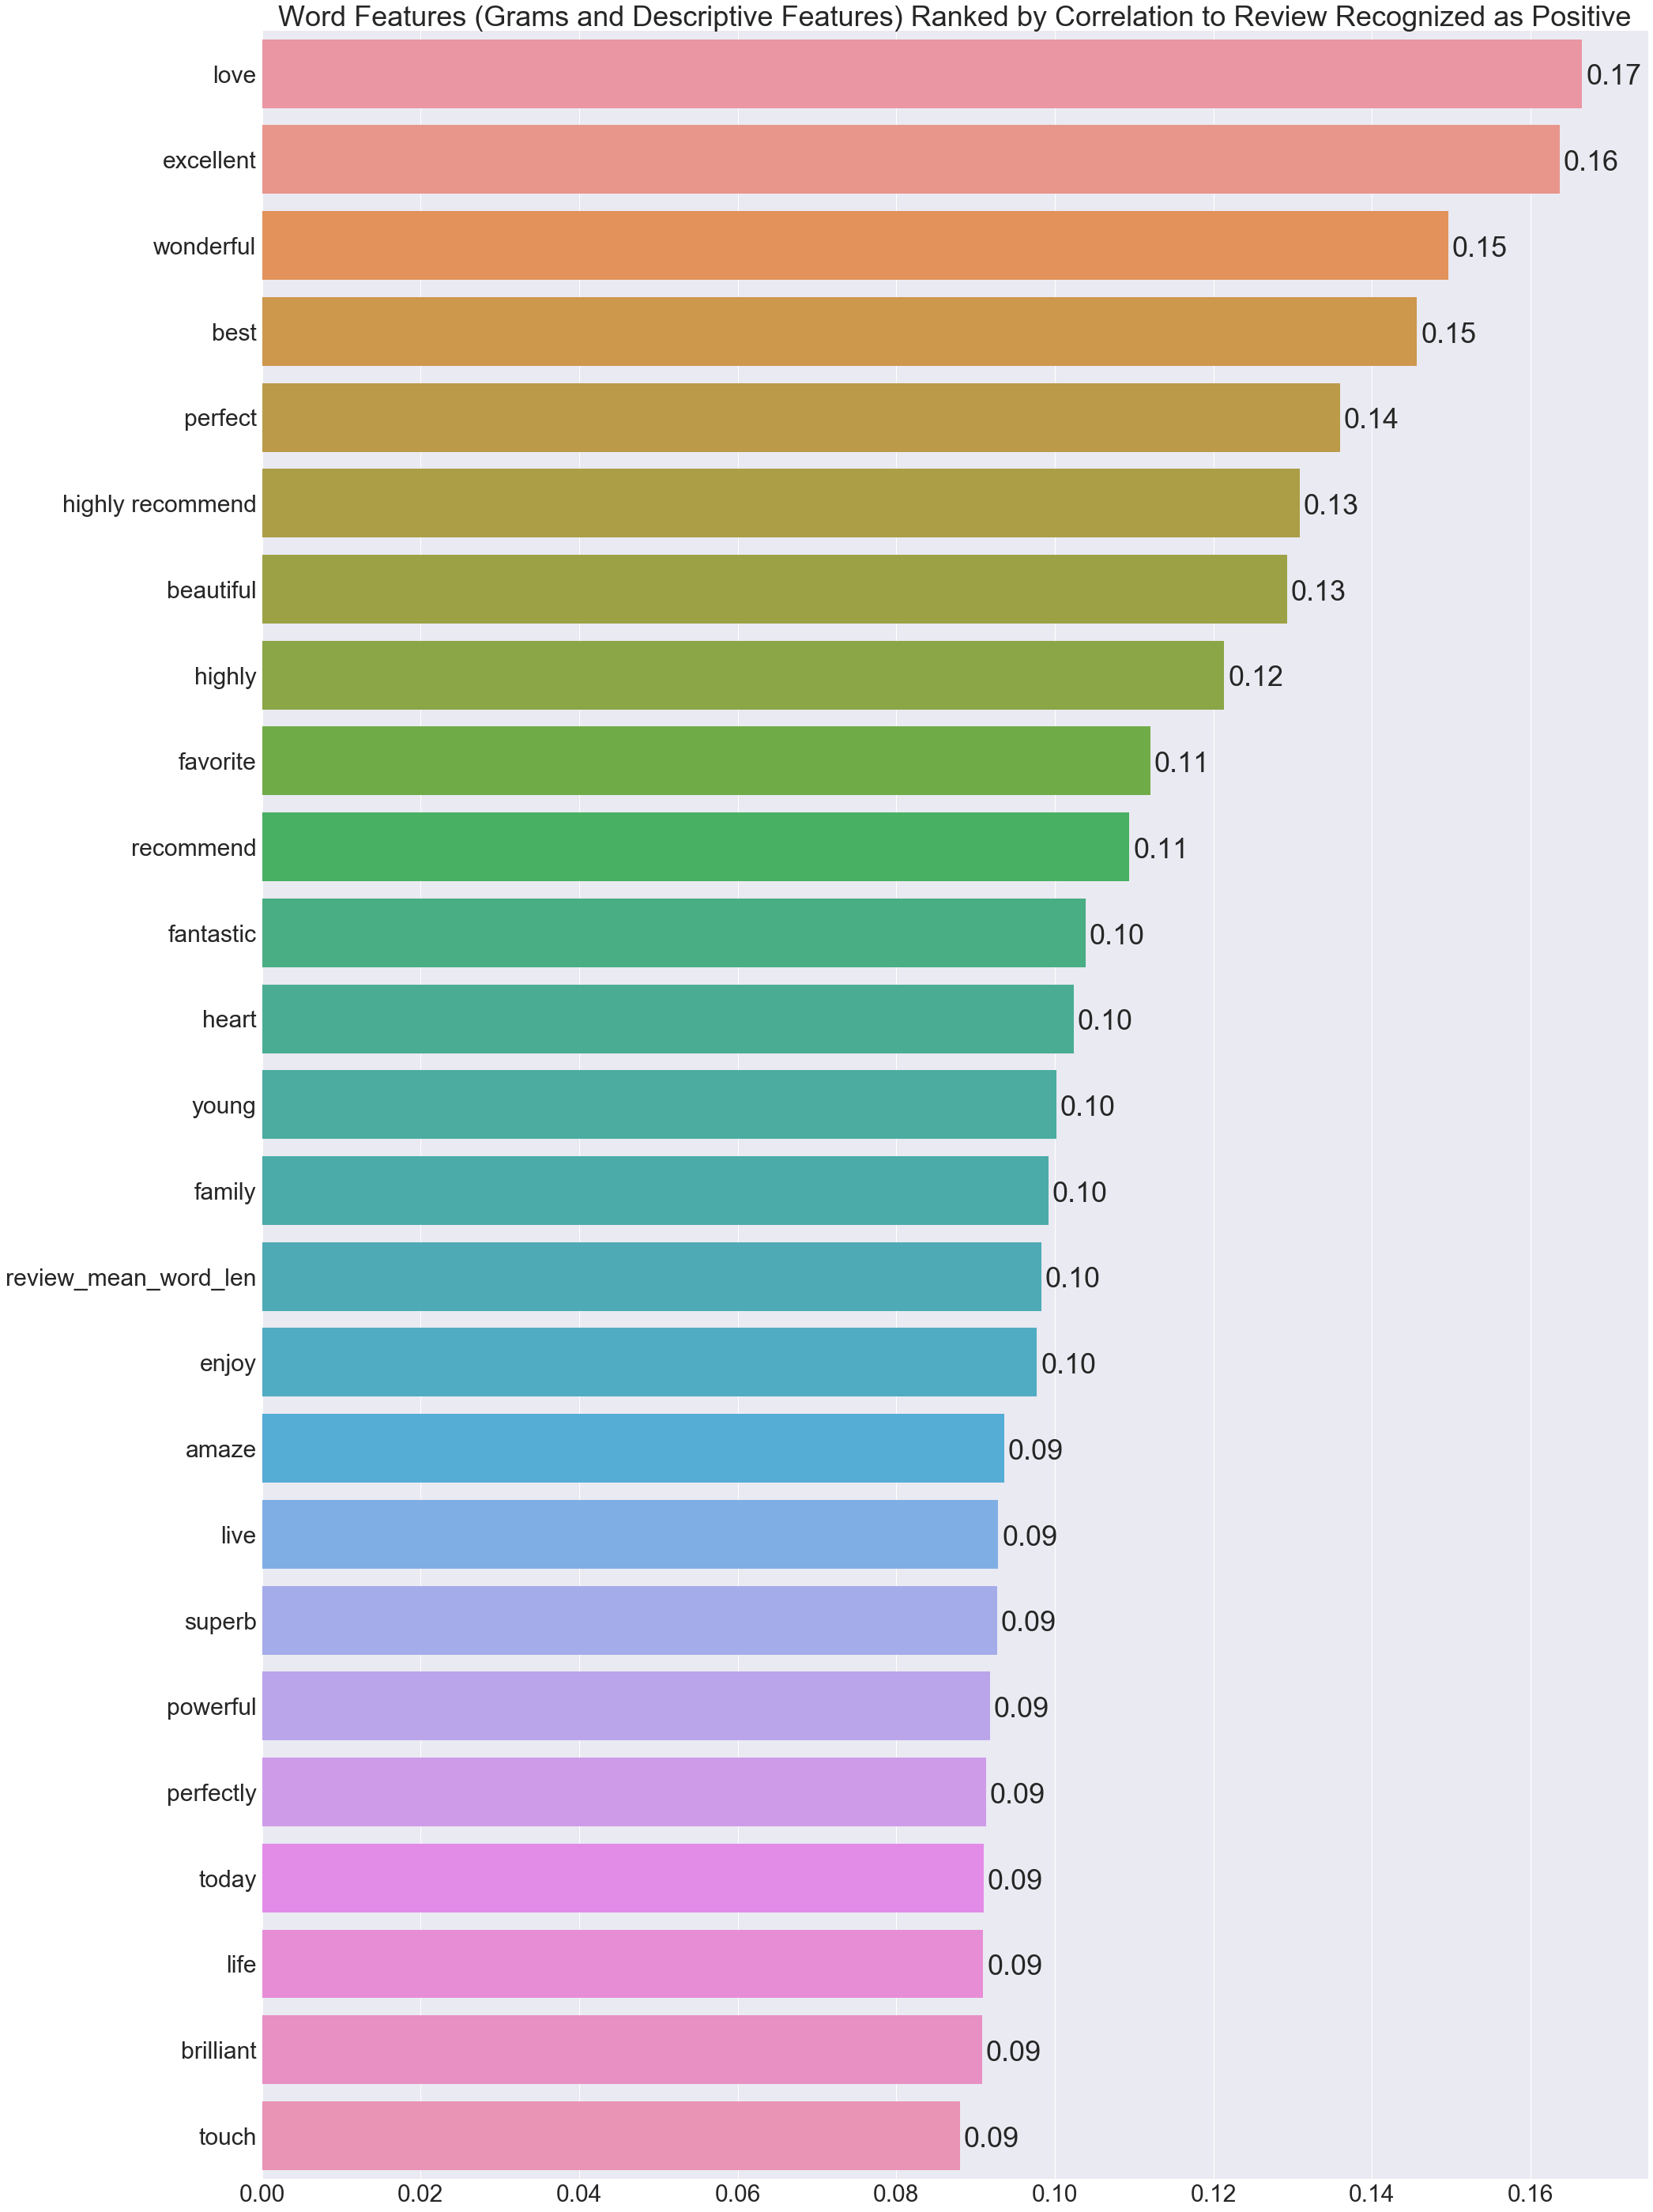

In [149]:
sns.set(font_scale=3)
plt.figure(figsize=(28,50))
plt.title("Word Features (Grams and Descriptive Features) Ranked by Correlation to Review Recognized as Positive")
ax=sns.barplot(y=tvec_corr.sort_values(ascending=False)[1:].head(25).index,\
            x=tvec_corr.sort_values(ascending=False)[1:].head(25),orient='h')

for p in ax.patches:
    width = p.get_width()
    plt.text(0.0005+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='left', va='center') 

plt.show()

In [150]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('../spooky_nlp_tut/glove.840B.300d.txt')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:53, 12626.27it/s]

Found 2196016 word vectors.


In [151]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [152]:
def glove_clean(raw_text):
    # split words and lowercase
    raw_text = BeautifulSoup(raw_text, 'lxml').get_text()
    
    words = raw_text.lower().split() 
    # convert contractions into individual words
    words=[APPO[word] if word in APPO else word for word in words]
    # join words
    words=" ".join(words)
    # return only words
    letters_only = re.sub("[^a-zA-Z]", " ", words)
    words=tokenizer.tokenize(letters_only)
    #words=[lem.lemmatize(word, "v") for word in words]
    #words = [w for w in words if not w in eng_stopwords]
    clean_sent=" ".join(words)

    
    return clean_sent

In [153]:
merged['glove_cleaned']=merged['review'].apply(glove_clean)
merged['glove_cleaned'][0]

u'with all this stuff going down at the moment with mj I have started listening to his music watching the odd documentary here and there watched the wiz and watched moonwalker again maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent moonwalker is part biography part feature film which i remember going to see at the cinema when it was originally released some of it has subtle messages about mj s feeling towards the press and also the obvious message of drugs are bad m kay visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him the actual feature film bit when it finally starts is only on for minutes o

In [154]:
# glove for request and title
stop_words = stopwords.words('english')
glove_review = [sent2vec(x) for x in tqdm(merged['glove_cleaned'])]
glove_review=np.array(glove_review)

100%|██████████| 5000/5000 [00:13<00:00, 362.36it/s]


In [155]:
glove_df=pd.DataFrame(glove_review)
glove_df.columns=[str(x)+'_glove' for x in list(glove_df)]
glove_df.head(1)

,0_glove,1_glove,2_glove,3_glove,4_glove,5_glove,6_glove,7_glove,8_glove,9_glove,...,290_glove,291_glove,292_glove,293_glove,294_glove,295_glove,296_glove,297_glove,298_glove,299_glove
0,-0.018061,0.021548,-0.046993,-0.016647,0.031496,0.021879,0.009408,-0.06836,0.010071,0.623404,...,-0.046735,-0.005642,-0.020462,-0.003504,0.032572,0.010882,-0.020148,-0.010877,-0.00193,0.052507


In [156]:
glove_all_feats_copy=pd.concat([numeric_merged,glove_df],axis=1)
glove_all_feats=glove_all_feats_copy.copy()

# scale all features

for f in list(glove_all_feats):
    glove_all_feats[f]=StandardScaler().fit_transform(glove_all_feats[f].as_matrix().reshape(-1,1)).flatten()
glove_all_feats.head(1)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConvers

,review_count_word,review_count_unique_word,review_count_letters,review_mean_word_len,review_word_unique_percent,0_glove,1_glove,2_glove,3_glove,4_glove,...,290_glove,291_glove,292_glove,293_glove,294_glove,295_glove,296_glove,297_glove,298_glove,299_glove
0,1.067795,0.932842,0.88789,-1.024603,-1.475887,0.163327,-0.106778,-1.220015,0.10735,0.861596,...,0.070154,-1.196264,-0.318687,-0.572757,0.324335,-0.201355,-0.525164,0.704175,-0.150585,2.374555


In [157]:
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q,random_state=1).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features,random_state=0).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [158]:
def clustering_silhoutte(command,num_features=5):
    if num_features:
        pfa = PFA(n_features=num_features)
        pfa.fit(glove_all_feats.values)
        column_indices = pfa.indices_
    
    if command=='partial':   
        tocluster = glove_all_feats.iloc[:,column_indices]
    else:
        tocluster = glove_all_feats
    
    clusters_list=[]
    sil_list=[]
    
    for s in [2,3]:
        clusterer = KMeans(n_clusters=s,random_state=42).fit(tocluster)
        #centers = clusterer.cluster_centers_
        c_preds = clusterer.predict(tocluster)
        silhouette_avg = silhouette_score(tocluster,c_preds,metric='euclidean')
        #print("For n_clusters =", s, "The average silhouette_score is:", silhouette_avg)
        clusters_list.append(s)
        sil_list.append(silhouette_avg)
    return zip(clusters_list,sil_list)


# checkmark 1: clustering with glove vectors

In [159]:
#glove_all_feats.to_csv('datasets/scaled_glove_feats.csv',index=False)
glove_all_feats=pd.read_csv('datasets/scaled_glove_feats.csv')
glove_all_feats.head()

,review_count_word,review_count_unique_word,review_count_letters,review_mean_word_len,review_word_unique_percent,0_glove,1_glove,2_glove,3_glove,4_glove,...,290_glove,291_glove,292_glove,293_glove,294_glove,295_glove,296_glove,297_glove,298_glove,299_glove
0,1.073246,0.936822,0.893813,-0.987099,-1.408596,0.171002,-0.114132,-1.225834,0.091039,0.870306,...,0.070112,-1.180046,-0.324587,-0.572102,0.338022,-0.197935,-0.517656,0.703154,-0.148147,2.345782
1,-0.441930,-0.505716,-0.385687,0.963888,-0.392096,-0.508724,0.830199,-0.089746,-1.009533,0.027681,...,-0.252624,0.413563,-1.276524,0.040531,2.607441,-1.085820,0.839299,-0.996436,-0.335889,0.726644
2,1.209089,1.720810,1.455776,1.740248,0.547692,-1.001734,-0.999186,1.097352,-0.456292,-0.317583,...,-0.627027,-0.742617,-0.184887,-1.178801,-1.769083,2.289183,0.474145,0.555615,-0.834825,-1.399519
3,0.717963,0.999541,0.933499,1.838041,0.205123,1.727333,1.167377,1.019304,0.632869,-0.024533,...,-0.299134,-0.971041,1.221162,-0.030510,0.289058,1.695962,0.917961,0.481282,-0.351821,-0.043481
4,0.874706,1.438574,1.028747,1.288899,1.061911,-1.147145,-1.378095,0.055877,0.633308,-0.608953,...,0.514307,-0.717315,0.079390,-0.001038,-1.238233,1.129138,0.368401,0.412569,0.229985,-0.340495


In [160]:
# the above function applied# the ab 
pfa = PFA(n_features=100)
pfa.fit(glove_all_feats.values)

# To get the transformed matrix
X2 = pfa.features_

# To get the column indices of the kept features
column_indices = pfa.indices_
print column_indices
#print X2.shape
#print X2

[121, 51, 72, 161, 29, 10, 41, 90, 35, 25, 245, 202, 126, 140, 270, 237, 143, 59, 55, 132, 205, 215, 162, 4, 113, 76, 77, 166, 151, 231, 195, 99, 24, 155, 32, 293, 116, 38, 194, 61, 63, 119, 252, 69, 186, 249, 6, 189, 8, 218, 112, 114, 58, 67, 12, 129, 200, 47, 268, 244, 150, 169, 198, 11, 109, 5, 234, 180, 115, 133, 301, 70, 283, 103, 256, 81, 57, 37, 62, 85, 294, 56, 135, 260, 228, 49, 71, 125, 0, 65, 222, 34, 255, 248, 60, 48, 158, 211, 146, 22]


In [162]:
for num in [300,250,200,150,100]:
    print str(num)
    print clustering_silhoutte('partial',num)

300
[(2, 0.07948478439042181), (3, 0.03605620484029605)]
250
[(2, 0.07469057078418555), (3, 0.036433149838188746)]
200
[(2, 0.07271782504858403), (3, 0.037732166700284044)]
150
[(2, 0.06340734834411178), (3, 0.03466260554649602)]
100
[(2, 0.07687641320575613), (3, 0.04067652121061692)]


In [163]:
for num in [80,60,40,20]:
    print str(num)
    print clustering_silhoutte('partial',num)

80
[(2, 0.07618534987555102), (3, 0.04321249307275134)]
60
[(2, 0.08078266542390425), (3, 0.04194356510292607)]
40
[(2, 0.07993915410241183), (3, 0.0442831886462536)]
20
[(2, 0.09363554679643267), (3, 0.06323412547548703)]


In [164]:
for num in [20,15,10,5]:
    print str(num)
    print clustering_silhoutte('partial',num)

20
[(2, 0.09363554679643267), (3, 0.06323412547548703)]
15
[(2, 0.09875314907868218), (3, 0.06483427167912184)]
10
[(2, 0.0960792693673784), (3, 0.08463422190528161)]
5
[(2, 0.15881020230636286), (3, 0.1388405854895883)]


In [165]:
for num in [4,3,2]:
    print str(num)
    print clustering_silhoutte('partial',num)

4
[(2, 0.19758214607689978), (3, 0.16900604759929302)]
3
[(2, 0.24220907335592773), (3, 0.2247384131690946)]
2
[(2, 0.326666203758804), (3, 0.31718310458895055)]


## max score with glove vector  is 0.32666 with 2 features

In [166]:
# the above function applied
pfa = PFA(n_features=2)
pfa.fit(glove_all_feats.values)

# To get the transformed matrix
X2 = pfa.features_

# To get the column indices of the kept features
column_indices = pfa.indices_
print column_indices
print X2.shape
# print X2

[51, 231]
(5000, 2)


In [167]:
clusterer = KMeans(n_clusters=3,random_state=42).fit(pd.DataFrame(X2))
#centers = clusterer.cluster_centers_
c_preds = clusterer.labels_
#print(centers)
print(c_preds[0:100])

[2 0 2 2 1 1 2 0 1 1 1 0 1 1 0 0 2 0 2 1 0 2 0 2 2 2 2 0 1 2 1 0 1 2 2 0 2
 0 0 1 1 2 1 0 2 1 1 0 2 2 1 0 2 1 0 1 2 2 2 2 1 1 1 2 2 2 0 2 1 0 2 0 0 1
 2 1 0 0 0 0 2 0 0 0 2 0 1 0 0 2 2 2 0 2 2 0 2 0 2 0]


# checkpoint 2: clustering with tfidf vector - cannot be completed bc of processing power

In [168]:
tf_all_feats_copy=pd.concat([numeric_merged,merged_tvec],axis=1)
tf_all_feats=tf_all_feats_copy.copy()

# scale all features

for f in list(tf_all_feats):
    tf_all_feats[f]=StandardScaler().fit_transform(tf_all_feats[f].as_matrix().reshape(-1,1)).flatten()
tf_all_feats.head(1)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConvers

,review_count_word,review_count_unique_word,review_count_letters,review_mean_word_len,review_word_unique_percent,aag,aamir,aaron,abandon,abandon baby,...,zombie movies,zombie relate,zombie remake,zombies,zombies come,zone,zoo,zoom,zorro,zuniga
0,1.067795,0.932842,0.88789,-1.024603,-1.475887,-0.024311,-0.023367,-0.024387,-0.100453,-0.024217,...,-0.030464,-0.024067,-0.024114,-0.089559,-0.023779,-0.067551,-0.032965,-0.042871,-0.022976,-0.023191


In [169]:
X=tf_all_feats
y=c_preds
selector=SelectKBest(score_func=f_classif, k=1000)
selector.fit(X,y)

SelectKBest(k=1000, score_func=<function f_classif at 0x1a17a0b9b0>)

In [170]:
import_features=pd.DataFrame(zip(list(tf_all_feats),selector.scores_)).sort_values(by=[1],ascending=False)
import_features.columns=['feature','score']
import_features.head(25)

,feature,score
3,review_mean_word_len,125.758020
26117,think,57.297041
14383,like,32.095994
28540,watch,31.790965
10322,french,31.311460
21010,production,30.607655
17896,movies,26.693686
6206,dance,25.778749
1,review_count_unique_word,24.726761
17161,movie,24.099129


In [171]:
top_25_features=import_features[:25]['feature'].tolist()
tf_complete_cluster=tf_all_feats.copy()

tf_complete_cluster['cluster']=c_preds
top_25_features.append('cluster')
tf_complete_cluster_top25=tf_complete_cluster[top_25_features]
tf_complete_cluster_top25.head()

,review_mean_word_len,think,like,watch,french,production,movies,dance,review_count_unique_word,movie,...,time,ago,feature,game,character,worst,use,really,happen,cluster
0,-1.024603,1.076485,0.934171,1.327020,-0.147121,-0.239657,-0.468854,2.411530,0.932842,0.245015,...,-0.743572,-0.189048,4.145959,-0.165413,0.374417,-0.297605,-0.393664,1.194333,-0.337626,2
1,0.718803,-0.634673,0.426512,0.766987,-0.147121,-0.239657,-0.468854,-0.176897,-0.497757,0.520714,...,-0.743572,-0.189048,-0.243316,-0.165413,-0.637803,-0.297605,-0.393664,-0.592248,-0.337626,0
2,1.606446,-0.634673,-0.039569,-0.665310,-0.147121,-0.239657,-0.468854,-0.176897,1.718885,-0.439326,...,-0.743572,-0.189048,-0.243316,-0.165413,-0.637803,-0.297605,1.223326,-0.592248,-0.337626,2
3,1.839561,0.489196,-0.871839,-0.665310,-0.147121,-0.239657,-0.468854,-0.176897,0.995725,-0.351672,...,-0.743572,-0.189048,-0.243316,-0.165413,0.487825,-0.297605,-0.393664,-0.592248,-0.337626,2
4,1.054429,-0.634673,-0.871839,0.322176,3.418800,-0.239657,-0.468854,-0.176897,1.451630,-0.395142,...,0.961595,-0.189048,-0.243316,-0.165413,-0.637803,-0.297605,-0.393664,-0.592248,-0.337626,1


In [172]:
tf_cluster_0=tf_complete_cluster_top25[tf_complete_cluster_top25.cluster==0]
tf_cluster_1=tf_complete_cluster_top25[tf_complete_cluster_top25.cluster==1]
tf_cluster_2=tf_complete_cluster_top25[tf_complete_cluster_top25.cluster==2]


tf_cluster_0=tf_cluster_0.drop(columns=['cluster'])
tf_cluster_1=tf_cluster_1.drop(columns=['cluster'])
tf_cluster_2=tf_cluster_2.drop(columns=['cluster'])

In [173]:
tf_cluster_0.mean().sort_values(ascending=False)

movies                      0.149703
good                        0.141131
movie                       0.084528
worst                      -0.021719
american                   -0.024689
watch                      -0.026833
feature                    -0.040108
like                       -0.040525
saw                        -0.041924
musical                    -0.056198
really                     -0.057043
culture                    -0.063385
review_count_unique_word   -0.065743
review_count_letters       -0.067546
production                 -0.069291
game                       -0.070788
dance                      -0.072145
review_mean_word_len       -0.072572
think                      -0.075477
ago                        -0.089496
french                     -0.092360
happen                     -0.101196
time                       -0.102342
character                  -0.111613
use                        -0.131166
dtype: float64

In [174]:
tf_cluster_1.mean().sort_values(ascending=False)

review_mean_word_len        0.315919
french                      0.163762
production                  0.162827
dance                       0.149593
review_count_unique_word    0.146588
culture                     0.143177
review_count_letters        0.142282
american                    0.138626
musical                     0.132976
feature                     0.126465
character                   0.107964
use                         0.074042
happen                     -0.029982
time                       -0.040597
ago                        -0.054899
game                       -0.071571
really                     -0.077140
saw                        -0.096144
good                       -0.097842
worst                      -0.102973
movies                     -0.116323
like                       -0.131750
watch                      -0.138512
movie                      -0.143427
think                      -0.161735
dtype: float64

In [175]:
tf_cluster_2.mean().sort_values(ascending=False)

think                       0.176101
like                        0.129079
watch                       0.124887
ago                         0.103583
game                        0.103569
saw                         0.102665
time                        0.101398
really                      0.098424
worst                       0.094059
happen                      0.092451
movie                       0.052293
use                         0.033033
character                  -0.006455
movies                     -0.013241
good                       -0.021570
french                     -0.062555
review_count_letters       -0.063060
musical                    -0.063688
dance                      -0.065526
culture                    -0.066602
review_count_unique_word   -0.067606
feature                    -0.069717
production                 -0.077657
american                   -0.089640
review_mean_word_len       -0.193100
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

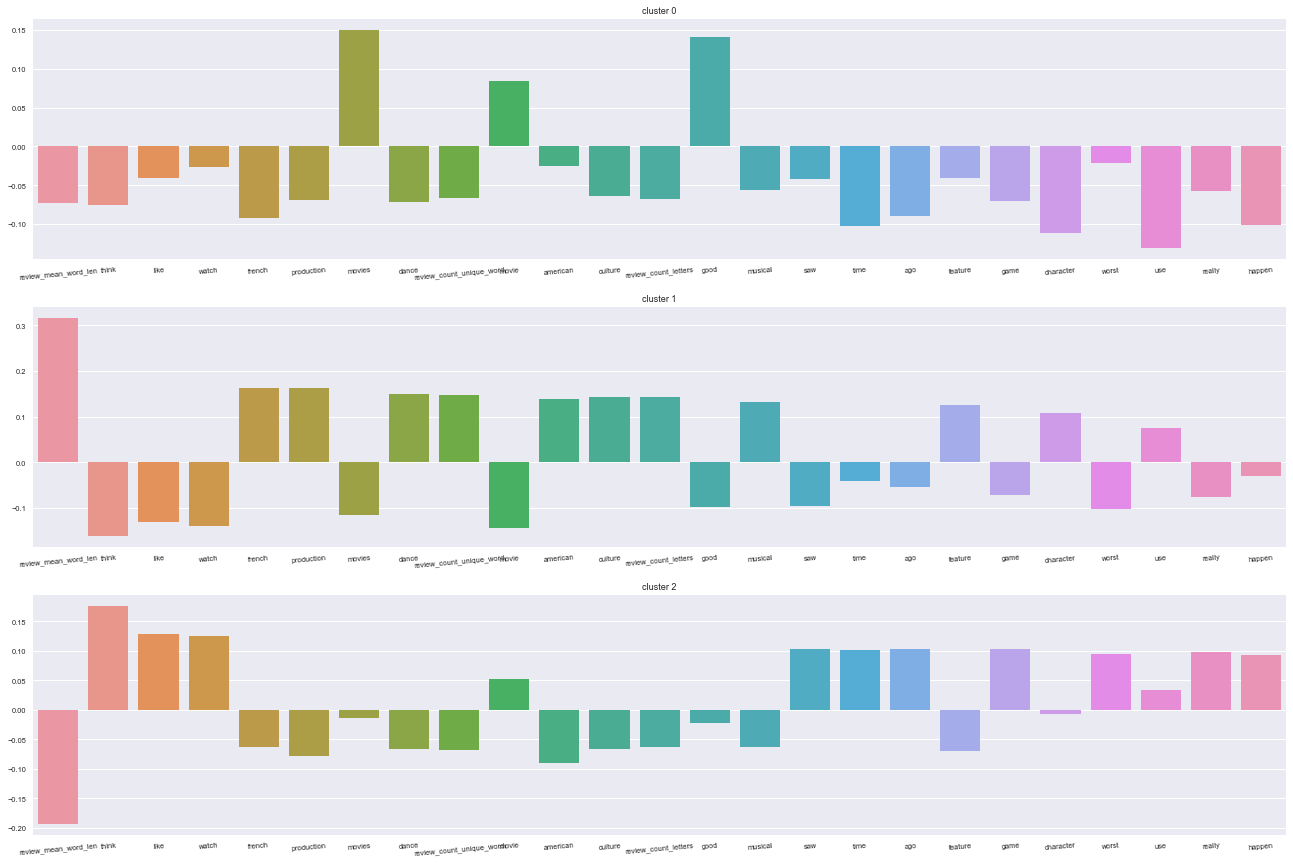

In [191]:
plt.figure(figsize=(20,15))
sns.set(font_scale=0.75)

plt.subplot(311)
plt.title('cluster 0')
sns.barplot(x=tf_cluster_0.columns,y=tf_cluster_0.mean())
plt.xticks(rotation=5)
plt.subplot(312)
plt.title('cluster 1')
sns.barplot(x=tf_cluster_1.columns,y=tf_cluster_1.mean())
plt.xticks(rotation=5)
plt.subplot(313)
plt.title('cluster 2')
sns.barplot(x=tf_cluster_2.columns,y=tf_cluster_2.mean())
plt.xticks(rotation=5)

In [186]:
tf_cluster_2.mean().sort_values(ascending=False)

movies                      0.149703
good                        0.141131
movie                       0.084528
worst                      -0.021719
american                   -0.024689
watch                      -0.026833
feature                    -0.040108
like                       -0.040525
saw                        -0.041924
musical                    -0.056198
really                     -0.057043
culture                    -0.063385
review_count_unique_word   -0.065743
review_count_letters       -0.067546
production                 -0.069291
game                       -0.070788
dance                      -0.072145
review_mean_word_len       -0.072572
think                      -0.075477
ago                        -0.089496
french                     -0.092360
happen                     -0.101196
time                       -0.102342
character                  -0.111613
use                        -0.131166
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

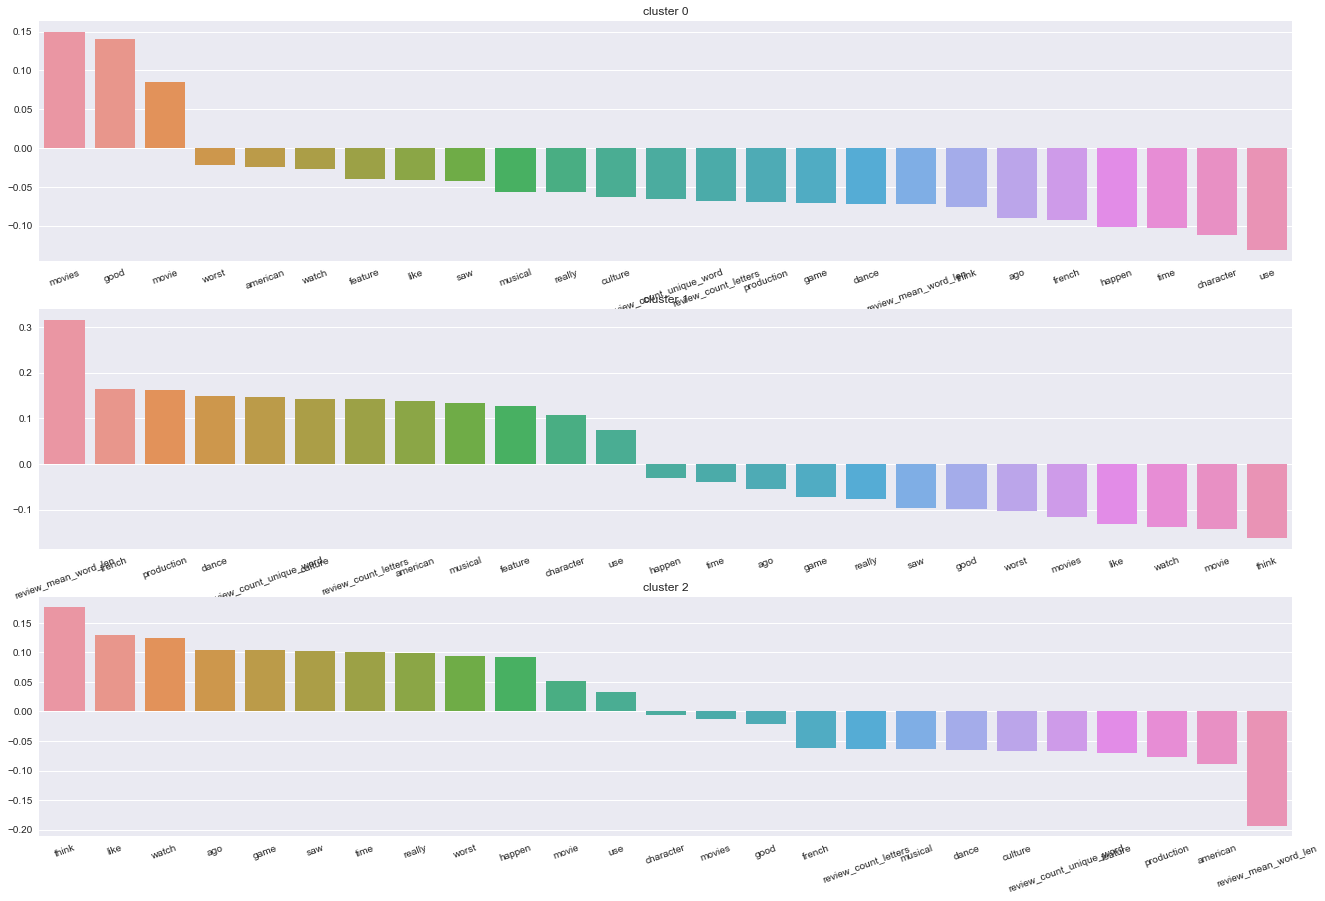

In [192]:
plt.figure(figsize=(20,15))
sns.set(font_scale=1)

plt.subplot(311)
plt.title('cluster 0')
sns.barplot(x=tf_cluster_0.mean().sort_values(ascending=False).index,y=tf_cluster_0.mean().sort_values(ascending=False))
plt.xticks(rotation=20)

plt.subplot(312)
plt.title('cluster 1')
sns.barplot(x=tf_cluster_1.mean().sort_values(ascending=False).index,y=tf_cluster_1.mean().sort_values(ascending=False))
plt.xticks(rotation=20)

plt.subplot(313)
plt.title('cluster 2')
sns.barplot(x=tf_cluster_2.mean().sort_values(ascending=False).index,y=tf_cluster_2.mean().sort_values(ascending=False))

plt.xticks(rotation=20)

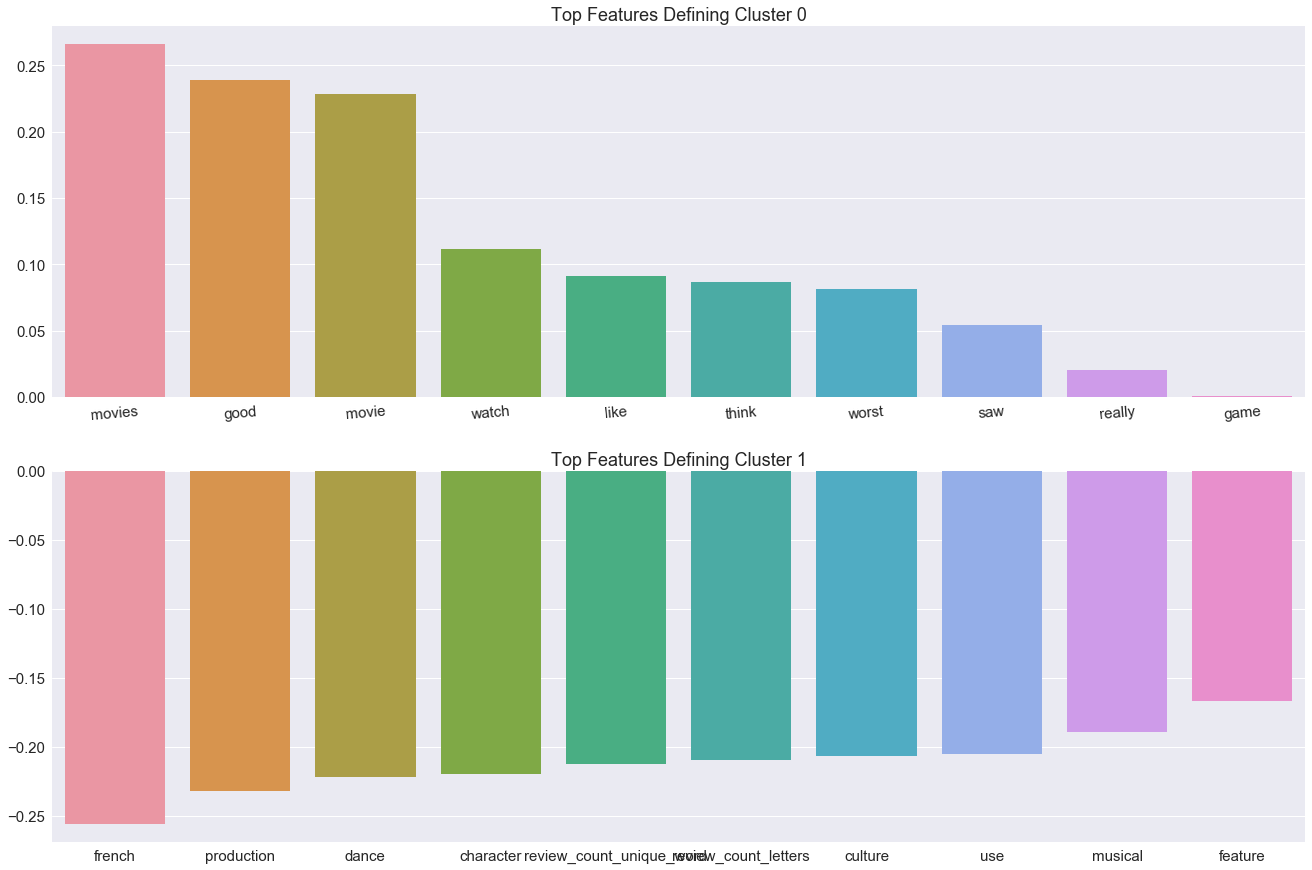

In [177]:
cluster_diff=tf_cluster_0.mean()-tf_cluster_1.mean()
cluster_diff=cluster_diff.sort_values(ascending=False)[:-1]
plt.figure(figsize=(20,15))
sns.set(font_scale=1.5)
plt.subplot(211)
plt.title('Top Features Defining Cluster 0')
sns.barplot(x=cluster_diff.index[:10],y=cluster_diff[:10])
plt.xticks(rotation=5)

plt.subplot(212)
plt.title('Top Features Defining Cluster 1')
sns.barplot(x=cluster_diff.sort_values(ascending=True).index[:10],y=cluster_diff.sort_values(ascending=True)[:10])

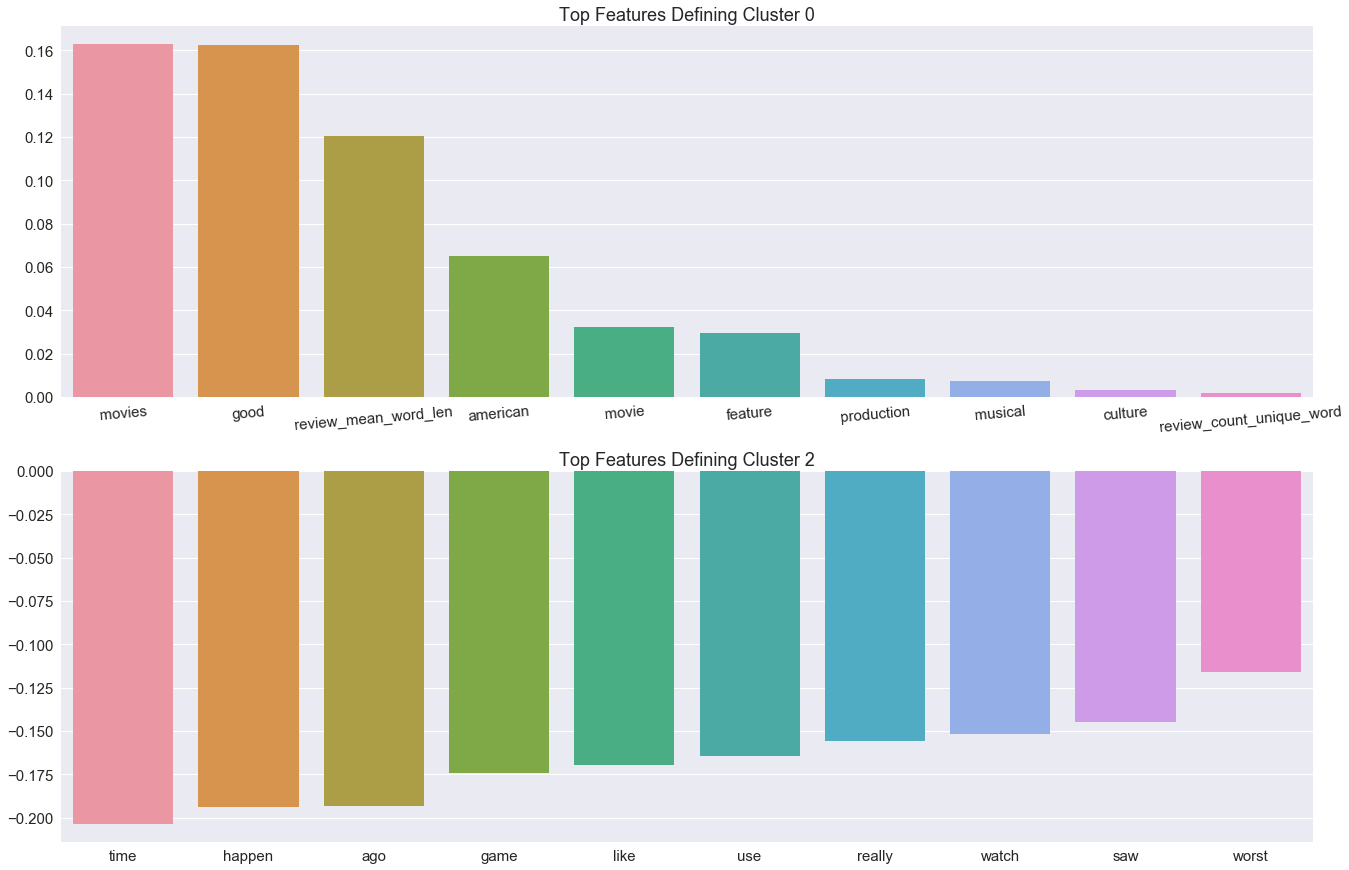

In [178]:
cluster_diff=tf_cluster_0.mean()-tf_cluster_2.mean()
cluster_diff=cluster_diff.sort_values(ascending=False)[:-1]
plt.figure(figsize=(20,15))
sns.set(font_scale=1.5)
plt.subplot(211)
plt.title('Top Features Defining Cluster 0')
sns.barplot(x=cluster_diff.index[:10],y=cluster_diff[:10])
plt.xticks(rotation=5)

plt.subplot(212)
plt.title('Top Features Defining Cluster 2')
sns.barplot(x=cluster_diff.sort_values(ascending=True).index[:10],y=cluster_diff.sort_values(ascending=True)[:10])

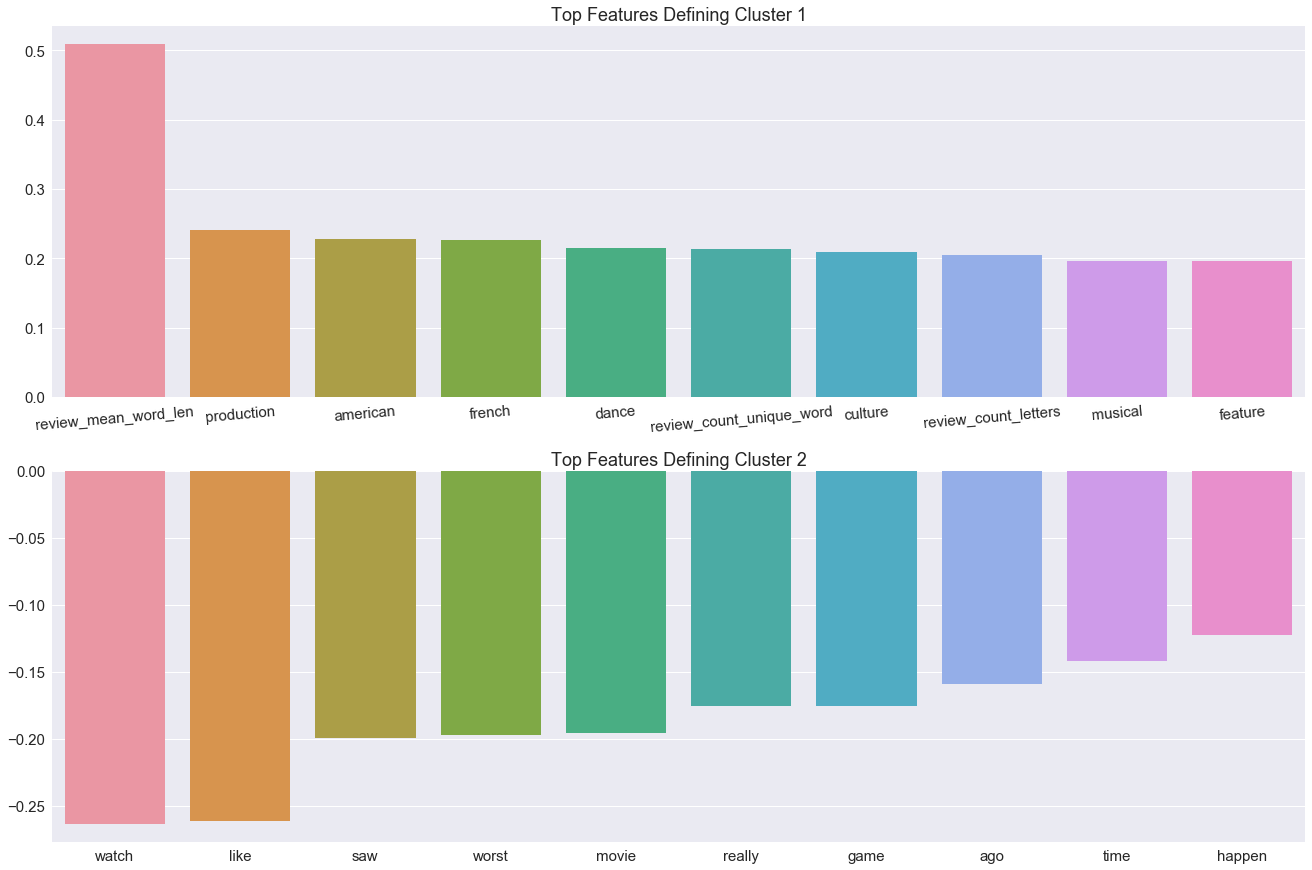

In [179]:
cluster_diff=tf_cluster_1.mean()-tf_cluster_2.mean()
cluster_diff=cluster_diff.sort_values(ascending=False)[:-1]
plt.figure(figsize=(20,15))
sns.set(font_scale=1.5)
plt.subplot(211)
plt.title('Top Features Defining Cluster 1')
sns.barplot(x=cluster_diff.index[:10],y=cluster_diff[:10])
plt.xticks(rotation=5)

plt.subplot(212)
plt.title('Top Features Defining Cluster 2')
sns.barplot(x=cluster_diff.sort_values(ascending=True).index[:10],y=cluster_diff.sort_values(ascending=True)[:10])

In [180]:
review_cluster=pd.concat([merged['review'],merged['cleaned_review'],pd.Series(c_preds)],axis=1)
review_cluster.columns=['review','cleaned_review','cluster']
review_cluster=pd.concat([review_cluster,tf_complete_cluster_top25],axis=1)
review_cluster=review_cluster.iloc[:,:-1]
review_cluster.head()

,review,cleaned_review,cluster,review_mean_word_len,think,like,watch,french,production,movies,...,saw,time,ago,feature,game,character,worst,use,really,happen
0,"""With all this stuff going down at the moment ...",stuff go moment mj I start listen music watch ...,2,-1.024603,1.076485,0.934171,1.327020,-0.147121,-0.239657,-0.468854,...,-0.323015,-0.743572,-0.189048,4.145959,-0.165413,0.374417,-0.297605,-0.393664,1.194333,-0.337626
1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertain fil...,0,0.718803,-0.634673,0.426512,0.766987,-0.147121,-0.239657,-0.468854,...,-0.323015,-0.743572,-0.189048,-0.243316,-0.165413,-0.637803,-0.297605,-0.393664,-0.592248,-0.337626
2,"""The film starts with a manager (Nicholas Bell...",film start manager nicholas bell give welcome ...,2,1.606446,-0.634673,-0.039569,-0.665310,-0.147121,-0.239657,-0.468854,...,-0.323015,-0.743572,-0.189048,-0.243316,-0.165413,-0.637803,-0.297605,1.223326,-0.592248,-0.337626
3,"""It must be assumed that those who praised thi...",must assume praise film greatest film opera ev...,2,1.839561,0.489196,-0.871839,-0.665310,-0.147121,-0.239657,-0.468854,...,-0.323015,-0.743572,-0.189048,-0.243316,-0.165413,0.487825,-0.297605,-0.393664,-0.592248,-0.337626
4,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...,1,1.054429,-0.634673,-0.871839,0.322176,3.418800,-0.239657,-0.468854,...,-0.323015,0.961595,-0.189048,-0.243316,-0.165413,-0.637803,-0.297605,-0.393664,-0.592248,-0.337626


In [181]:
review_cluster_0=review_cluster[review_cluster.cluster==0]
review_cluster_1=review_cluster[review_cluster.cluster==1]
review_cluster_2=review_cluster[review_cluster.cluster==2]

In [205]:
print 'clusters for top 2000 reviews sorted by review_mean_word_len (cluster 1 signature feature)'
print review_cluster.sort_values(by=['review_mean_word_len'],ascending=False)[['cleaned_review','cluster','review_mean_word_len']].head(2000)['cluster'].value_counts()

clusters for top 2000 reviews sorted by review_mean_word_len (cluster 1 signature feature)
1    825
2    656
0    519
Name: cluster, dtype: int64


## Commentary

Clusters aren't well defined as expected with low silhoutte score, but this project was still good practice for clustering with text data.